<a href="https://colab.research.google.com/github/hammamrobbani10/IntroGithub/blob/main/ARIMA_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library and Datasets

In [2]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.6 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from itertools import product
import pmdarima as pm
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [52]:
#Read customers file
customers = pd.read_csv('drive/MyDrive/ARIMA/customer.csv',sep=';')
customers.head(5)

,CustomerID,Age,Gender,Marital Status,Income
0,1,55,1,Married,"5,12"
1,2,60,1,Married,"6,23"
2,3,32,1,Married,"9,17"
3,4,31,1,Married,"4,87"
4,5,58,1,Married,"3,57"


In [53]:
#Read transactions file
transactions = pd.read_csv('drive/MyDrive/ARIMA/transaction.csv', sep=";")
transactions.head(5)

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
0,TR11369,328,01/01/2022,P3,7500,4,30000,12
1,TR16356,165,01/01/2022,P9,10000,7,70000,1
2,TR1984,183,01/01/2022,P1,8800,4,35200,4
3,TR35256,160,01/01/2022,P1,8800,7,61600,4
4,TR41231,386,01/01/2022,P9,10000,1,10000,4


In [54]:
#Read products file
products = pd.read_csv('drive/MyDrive/ARIMA/product.csv', sep=';')
products.head(5)

,ProductID,Product Name,Price
0,P1,Choco Bar,8800
1,P2,Ginger Candy,3200
2,P3,Crackers,7500
3,P4,Potato Chip,12000
4,P5,Thai Tea,4200


In [55]:
#Read stores file
stores = pd.read_csv('drive/MyDrive/ARIMA/store.csv', sep=';')
stores.head(5)

,StoreID,StoreName,GroupStore,Type,Latitude,Longitude
0,1,Prima Tendean,Prima,Modern Trade,"-6,2","106,816666"
1,2,Prima Kelapa Dua,Prima,Modern Trade,"-6,914864","107,608238"
2,3,Prima Kota,Prima,Modern Trade,"-7,797068","110,370529"
3,4,Gita Ginara,Gita,General Trade,"-6,966667","110,416664"
4,5,Bonafid,Gita,General Trade,"-7,250445","112,768845"


In [67]:
#Merging all data frame on transaction
df = pd.merge(transactions,customers,on='CustomerID')
df = pd.merge(df,products,on='ProductID',suffixes=('_cust','_prod'))
df = pd.merge(df,stores,on='StoreID')
df.sample(5)

,TransactionID,CustomerID,Date,ProductID,Price_cust,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,Product Name,Price_prod,StoreName,GroupStore,Type,Latitude,Longitude
1768,TR22429,7,06/10/2022,P4,12000,1,12000,7,31,0,Married,"4,57",Potato Chip,12000,Buana Indah,Buana,General Trade,"3,316694","114,590111"
1621,TR85377,316,03/11/2022,P7,9400,2,18800,7,45,0,Married,"9,49",Coffee Candy,9400,Buana Indah,Buana,General Trade,"3,316694","114,590111"
4115,TR19486,229,28/06/2022,P7,9400,3,28200,6,32,0,Married,"10,17",Coffee Candy,9400,Lingga,Lingga,Modern Trade,"-5,135399","119,42379"
2346,TR71949,270,07/09/2022,P9,10000,4,40000,9,49,1,Married,"8,81",Yoghurt,10000,Lingga,Lingga,Modern Trade,"-3,654703","128,190643"
4725,TR33009,267,21/05/2022,P8,16000,1,16000,4,22,0,Single,0,Oat,16000,Gita Ginara,Gita,General Trade,"-6,966667","110,416664"


In [68]:
#rename columns name to lowercase
col_name = {}
for i in df.columns:
    col_name[i] = i.lower().replace(' ','_')
df = df.rename(columns=col_name)
df.sample(5)

,transactionid,customerid,date,productid,price_cust,qty,totalamount,storeid,age,gender,marital_status,income,product_name,price_prod,storename,groupstore,type,latitude,longitude
2151,TR20698,343,10/07/2022,P4,12000,1,12000,5,29,0,Married,"2,26",Potato Chip,12000,Bonafid,Gita,General Trade,"-7,250445","112,768845"
2804,TR51628,444,04/09/2022,P2,3200,6,19200,3,53,0,Married,"15,31",Ginger Candy,3200,Prima Kota,Prima,Modern Trade,"-7,797068","110,370529"
2406,TR41323,186,08/11/2022,P2,3200,7,22400,9,34,1,Married,"4,02",Ginger Candy,3200,Lingga,Lingga,Modern Trade,"-3,654703","128,190643"
2481,TR21236,340,27/10/2022,P6,18000,2,36000,9,41,0,Single,"10,9",Cashew,18000,Lingga,Lingga,Modern Trade,"-3,654703","128,190643"
4119,TR46491,44,09/02/2022,P7,9400,2,18800,6,40,0,Married,"10,65",Coffee Candy,9400,Lingga,Lingga,Modern Trade,"-5,135399","119,42379"


## Data type

In [69]:
#Check datatype
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5020 entries, 0 to 5019
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   transactionid   5020 non-null   object
 1   customerid      5020 non-null   int64 
 2   date            5020 non-null   object
 3   productid       5020 non-null   object
 4   price_cust      5020 non-null   int64 
 5   qty             5020 non-null   int64 
 6   totalamount     5020 non-null   int64 
 7   storeid         5020 non-null   int64 
 8   age             5020 non-null   int64 
 9   gender          5020 non-null   int64 
 10  marital_status  4976 non-null   object
 11  income          5020 non-null   object
 12  product_name    5020 non-null   object
 13  price_prod      5020 non-null   int64 
 14  storename       5020 non-null   object
 15  groupstore      5020 non-null   object
 16  type            5020 non-null   object
 17  latitude        5020 non-null   object
 18  longitud

In [70]:
#Convert date data type
df['date'] = pd.to_datetime(df['date'])

df.sample(5)

,transactionid,customerid,date,productid,price_cust,qty,totalamount,storeid,age,gender,marital_status,income,product_name,price_prod,storename,groupstore,type,latitude,longitude
2023,TR95309,61,2022-02-27,P9,10000,5,50000,5,40,0,Married,7,Yoghurt,10000,Bonafid,Gita,General Trade,"-7,250445","112,768845"
549,TR45641,359,2022-12-04,P7,9400,6,56400,13,46,0,Married,"19,99",Coffee Candy,9400,Buana,Buana,General Trade,"-1,26916","116,825264"
3975,TR48182,199,2022-11-19,P3,7500,6,45000,6,41,0,Married,"7,9",Crackers,7500,Lingga,Lingga,Modern Trade,"-5,135399","119,42379"
2095,TR2837,412,2022-03-09,P10,15000,1,15000,5,18,1,Single,0,Cheese Stick,15000,Bonafid,Gita,General Trade,"-7,250445","112,768845"
3002,TR8134,5,2022-10-02,P5,4200,5,21000,14,58,1,Married,"3,57",Thai Tea,4200,Priangan,Priangan,Modern Trade,"-5,45","105,26667"


# Data cleaning

In [71]:
#Drop irrelevant columns
df = df[['date','qty']]
df= df.groupby('date')[['qty']].sum()
df.head(5)

,qty
date,
2022-01-01,49
2022-01-02,50
2022-01-03,76
2022-01-04,98
2022-01-05,67


In [14]:
#check dataset shape
df.shape

(365, 1)

In [15]:
df.to_csv(r"drive/MyDrive/ARIMA/df_forecasting.csv", index=False)

## Null Value

In [16]:
#Check null
df.isna().sum()

qty    0
dtype: int64

# Forecasting Data Preparation

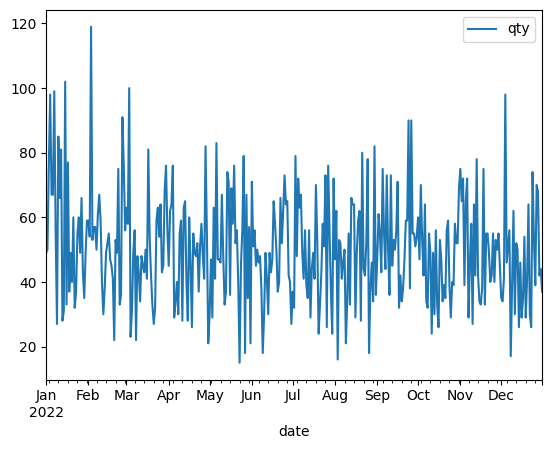

In [17]:
df.plot()
plt.show()

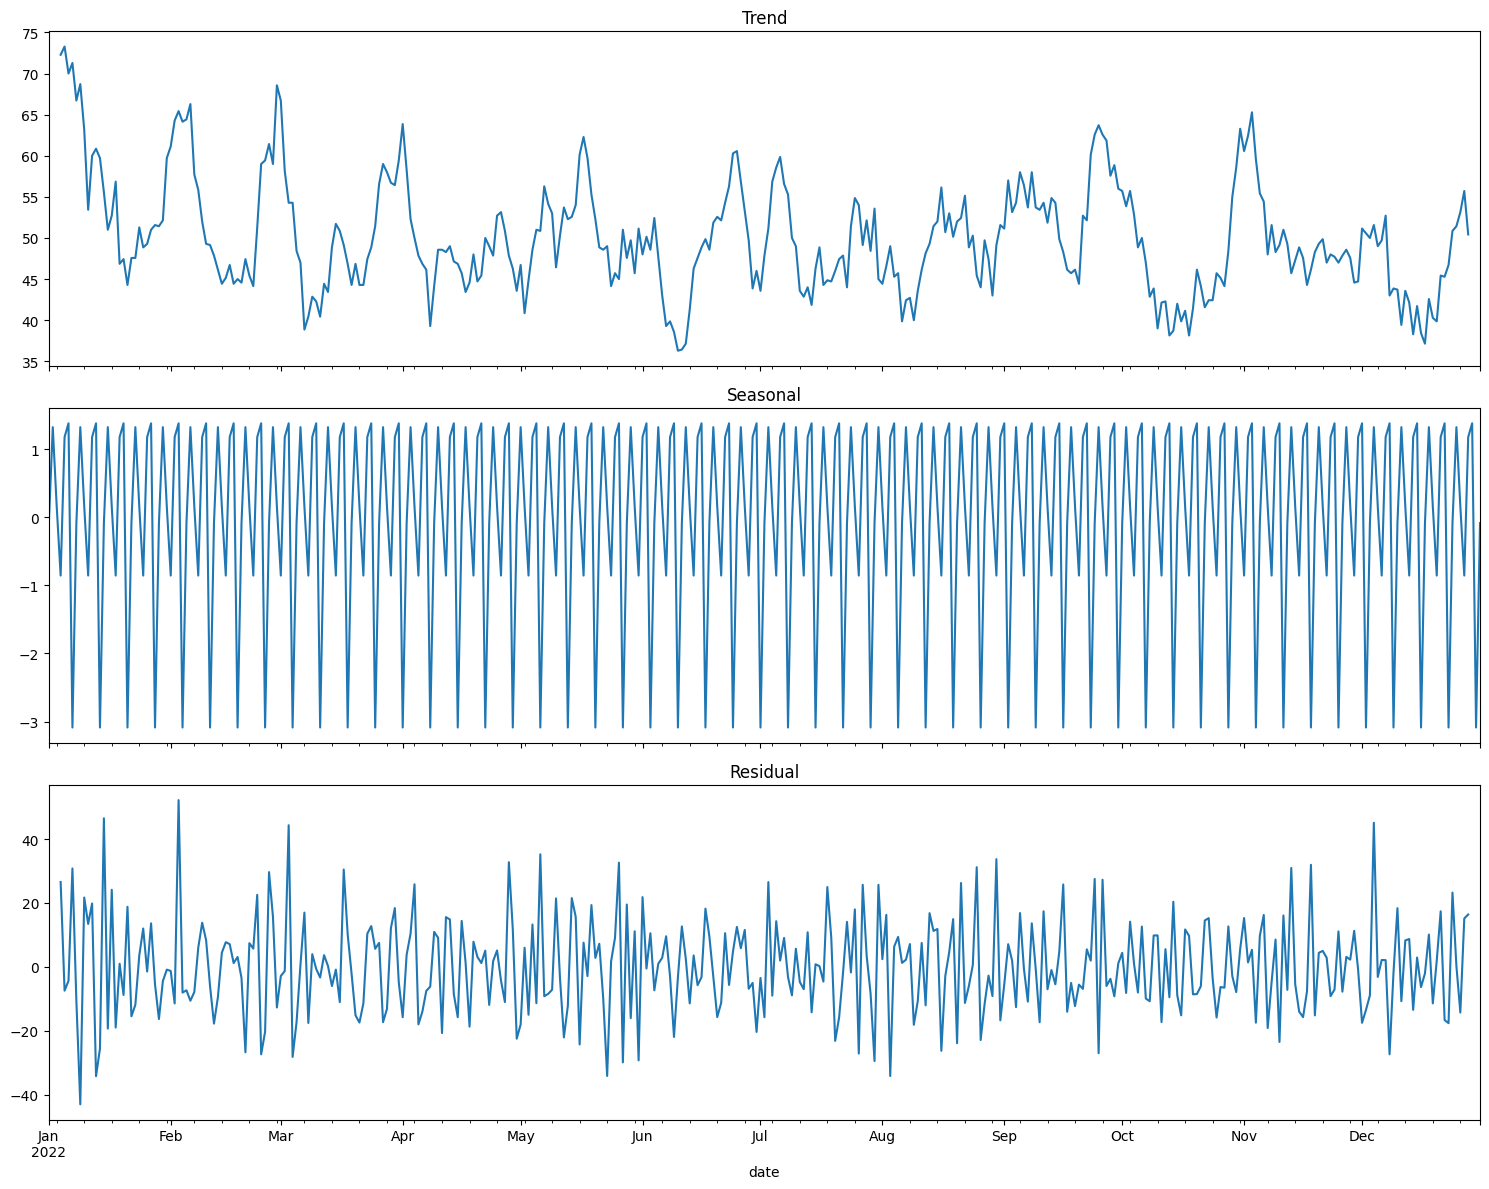

In [18]:
decompose = seasonal_decompose(df)

fig, ax = plt.subplots(3, 1, figsize=(15,12), sharex = True)
decompose.trend.plot(ax=ax[0])
ax[0].set_title('Trend')
decompose.seasonal.plot(ax=ax[1])
ax[1].set_title('Seasonal')
decompose.resid.plot(ax=ax[2])
ax[2].set_title('Residual')

plt.subplots_adjust(hspace=1)

plt.tight_layout()
plt.show()

## Transform Data

In [72]:
#Transform data to log
df = np.log(df)
df.head(5)

,qty
date,
2022-01-01,3.891820
2022-01-02,3.912023
2022-01-03,4.330733
2022-01-04,4.584967
2022-01-05,4.204693


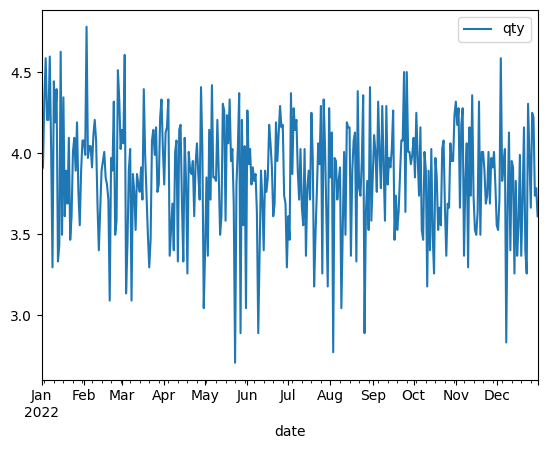

In [20]:
df.plot()
plt.show()

## Split data

In [21]:
# Splitting the data into training and testing sets
print (df.shape)
df_train = df.iloc[:-31]
df_test = df.iloc[-31:]
print (df_train.shape, df_test.shape)

(365, 1)
(334, 1) (31, 1)


## Check Data Stationary

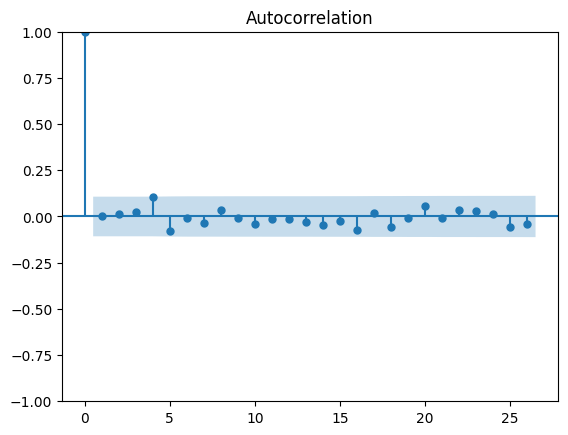

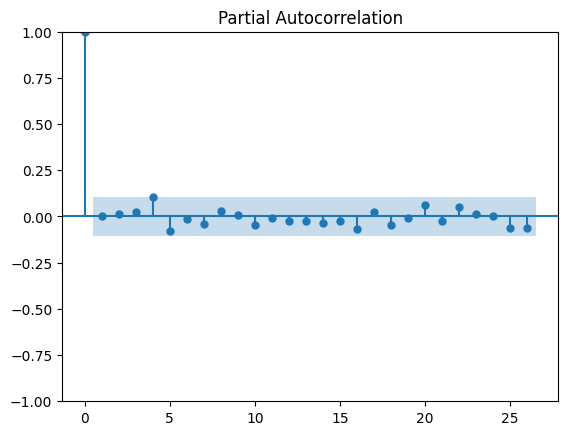

In [22]:
#ACF and PACF plot
acf = plot_acf(df_train['qty'])
pacf = plot_pacf(df_train['qty'])

In [23]:
#ADF test
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df_train)
print(f'ADF: {adf_test[0]}')
print(f'P-Value: {adf_test[1]}')
print(f'Num of Lags: {adf_test[2]}')
print(f'Num of Observations Used for ADF Regression and Critical Values Calculation: {adf_test[3]}')

# Statistical test to validate stationarity

# Ho = The data is not stationary
# Ha = The data is stationary

alpha = 0.05

if adf_test[1] <= alpha:
    print('Reject Ho. The data is stationary')
else:
    print('Fail to reject Ho. The data is not stationary')

ADF: -18.177843290187248
P-Value: 2.4374177848750526e-30
Num of Lags: 0
Num of Observations Used for ADF Regression and Critical Values Calculation: 333
Reject Ho. The data is stationary


Dari ACF dan PACF plot dan ADF test data sudah statonary dan bisa digunakan untuk ARIMA model.

# Model ARIMA
Pada model arima dibutuhkan parameter (p,d,q) untuk menghasilkan forecast yang akurat. Dilakukan 2 metode untuk mendapatkan parameter ini yaitu dengan auto-fit arima dan manual parameter tuning

## Modelling & Evaluation

In [24]:
#auto-fit ARIMA
auto_arima = pm.auto_arima(df_train['qty'], stepwise=False, seasonal=False, trace = True)
auto_arima.summary()
auto_arima

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1855.801, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1482.458, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1206.481, Time=0.32 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=1065.183, Time=0.44 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=941.289, Time=0.76 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=859.710, Time=0.87 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.99 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=1.03 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=259.233, Time=1.47 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=inf, Time=1.77 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=1.24 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=258.646, Time=2.61 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=3.36 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Ti

ARIMA(order=(2, 0, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [33]:
from itertools import product

def tune(z, y, x):
    model = ARIMA(df_train, order=(x, y, z))
    model_fit = model.fit()
    forecast_test = model_fit.forecast(len(df_test))
    df_plot = df[['qty']].iloc[-61:]

    df_plot['forecast'] = [None] * (len(df_plot) - len(forecast_test)) + list(forecast_test)

    mae = mean_absolute_error(df_test, forecast_test)
    mape = mean_absolute_percentage_error(df_test, forecast_test)
    rmse = np.sqrt(mean_squared_error(df_test, forecast_test))

    return mae, mape, rmse

# Parameter combinations
pval = [70, 75]
dval = [0, 1]
qval = [2]

combination = list(product(pval, dval, qval))

tuning_results = [(params, *tune(*params)) for params in combination]

columns = ['parameter', 'mae', 'mape', 'rmse']
tuning_df = pd.DataFrame(tuning_results, columns=columns)
best_results = tuning_df.sort_values(by='mae').head(5)

print(best_results)

    parameter       mae      mape      rmse
1  (70, 1, 2)  0.301043  0.081881  0.379461
2  (75, 0, 2)  0.306583  0.084172  0.388999
0  (70, 0, 2)  0.318849  0.087065  0.391249
3  (75, 1, 2)  0.321656  0.089473  0.415517


In [35]:
#Manual parameter tuning
model = ARIMA(df_train, order=(70, 1, 2))
model_fit = model.fit()

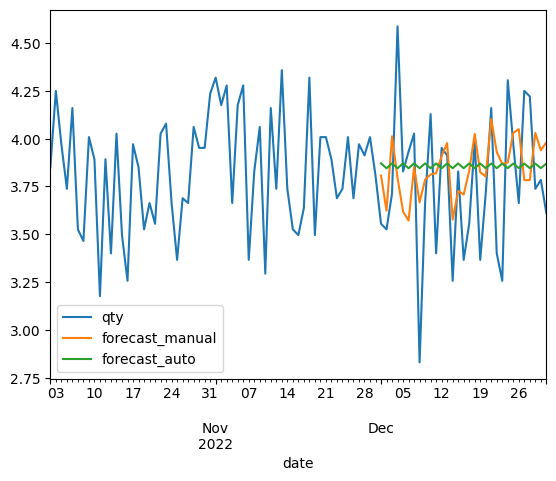

In [40]:
#plot forecasting
forecast_manual = model_fit.forecast(len(df_test))
forecast_auto = auto_arima.predict(len(df_test))

df_plot = df[['qty']].iloc[-91:]

df_plot['forecast_manual'] = [None]*(len(df_plot)-len(forecast_manual)) + list(forecast_manual)
df_plot['forecast_auto'] = [None]*(len(df_plot)-len(forecast_auto)) + list(forecast_auto)

df_plot.plot()
plt.show()

In [41]:
#Manual parameter tuning metrics

mae = mean_absolute_error(df_test, forecast_manual)
mape = mean_absolute_percentage_error(df_test, forecast_manual)
rmse = np.sqrt(mean_squared_error(df_test, forecast_manual))

print(f'mae - manual: {round(mae,4)}')
print(f'mape - manual: {round(mape,4)}')
print(f'rmse - manual: {round(rmse,4)}')

mae - manual: 0.3026
mape - manual: 0.0831
rmse - manual: 0.3656


In [42]:
#Auto-fit ARIMA metrics

mae = mean_absolute_error(df_test, forecast_auto)
mape = mean_absolute_percentage_error(df_test, forecast_auto)
rmse = np.sqrt(mean_squared_error(df_test, forecast_auto))

print(f'mae - auto: {round(mae,4)}')
print(f'mape - auto: {round(mape,4)}')
print(f'rmse - auto: {round(rmse,4)}')

mae - auto: 0.3039
mape - auto: 0.0846
rmse - auto: 0.378


Dari metric di atas kita pilih ARIMA model dengan parameters (70,1,2)

## Forecasting Overall Quantity

In [73]:
#Apply model to forecast data
model = ARIMA(df, order=(70, 1, 2))
model_fit = model.fit()
forecast = model_fit.forecast(steps=30)

In [74]:
#Re-trasnform data
df = np.exp(df)
forecast = np.exp(forecast)

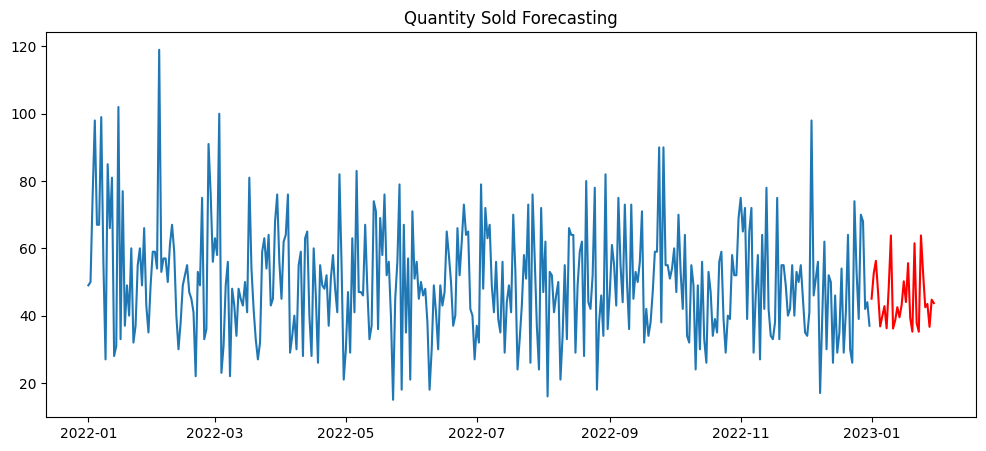

In [75]:
#Plot forecasting
plt.figure(figsize=(12,5))
plt.plot(df)
plt.plot(forecast,color='red')
plt.title('Quantity Sold Forecasting')
plt.show()

In [76]:
forecast.mean()

45.189187201298374

Dari forecasting di atas dapat disimpulkan bahwa untuk quantity penjualan bulan depan adalah sekitar rata-rata  43 pcs per harinya.